In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import, division, print_function

import re
import os
import sys
import datetime
import itertools
import warnings

import pandas as pd
import pandas_datareader.data as web
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

# Display and Plotting
import matplotlib.pyplot as plt
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress

from IPython.display import set_matplotlib_formats, Image

C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 3. Time series decomposition

In the above data, a long term cyclic pattern seems to be non-existent. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:

$$
y_t = f(d_t, s_t, \varepsilon_t)
$$

where $d_t$ is the trend component, $s_t$ is the seasonal component and $\varepsilon_t$ is purely random noise.

## 3.1 Time series components

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

<ol>
<li><strong>Trend</strong> – overall direction of the series i.e. upwards, downwards etc</li>
<li><strong>Seasonality</strong> – monthly or yearly patterns</li>
<li><strong>Cycle</strong> – long-term business cycles, they usually come after 5 or 7 years</li>
<li><strong>Noise</strong> – irregular remainder left after extraction of all the components</li>
</ol>

Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

## 3.2 Trend

From the preliminary plots so far it is obvious that there is some kind of increasing <strong>trend</strong> in the series along with seasonal variation. Since stationarity is a vital assumption we need to verify if our time series follows a stationary process or not. We can do so by

<ol>
<li><strong>Plots</strong>: review the time series plot of our data and visually check if there are any obvious trends or seasonality</li>
<li><strong>Statistical tests</strong>: use statistical tests to check if the expectations of stationarity are met or have been violated.</li>
</ol>

### Moving averages over time

One way to identify a trend pattern is to use moving averages over a specific window of past observations. This smoothes the curve by averaging adjacent values over the specified time horizon (window).

In [5]:
# load passenger data set and save to DataFrame
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
y = df['n_passengers']

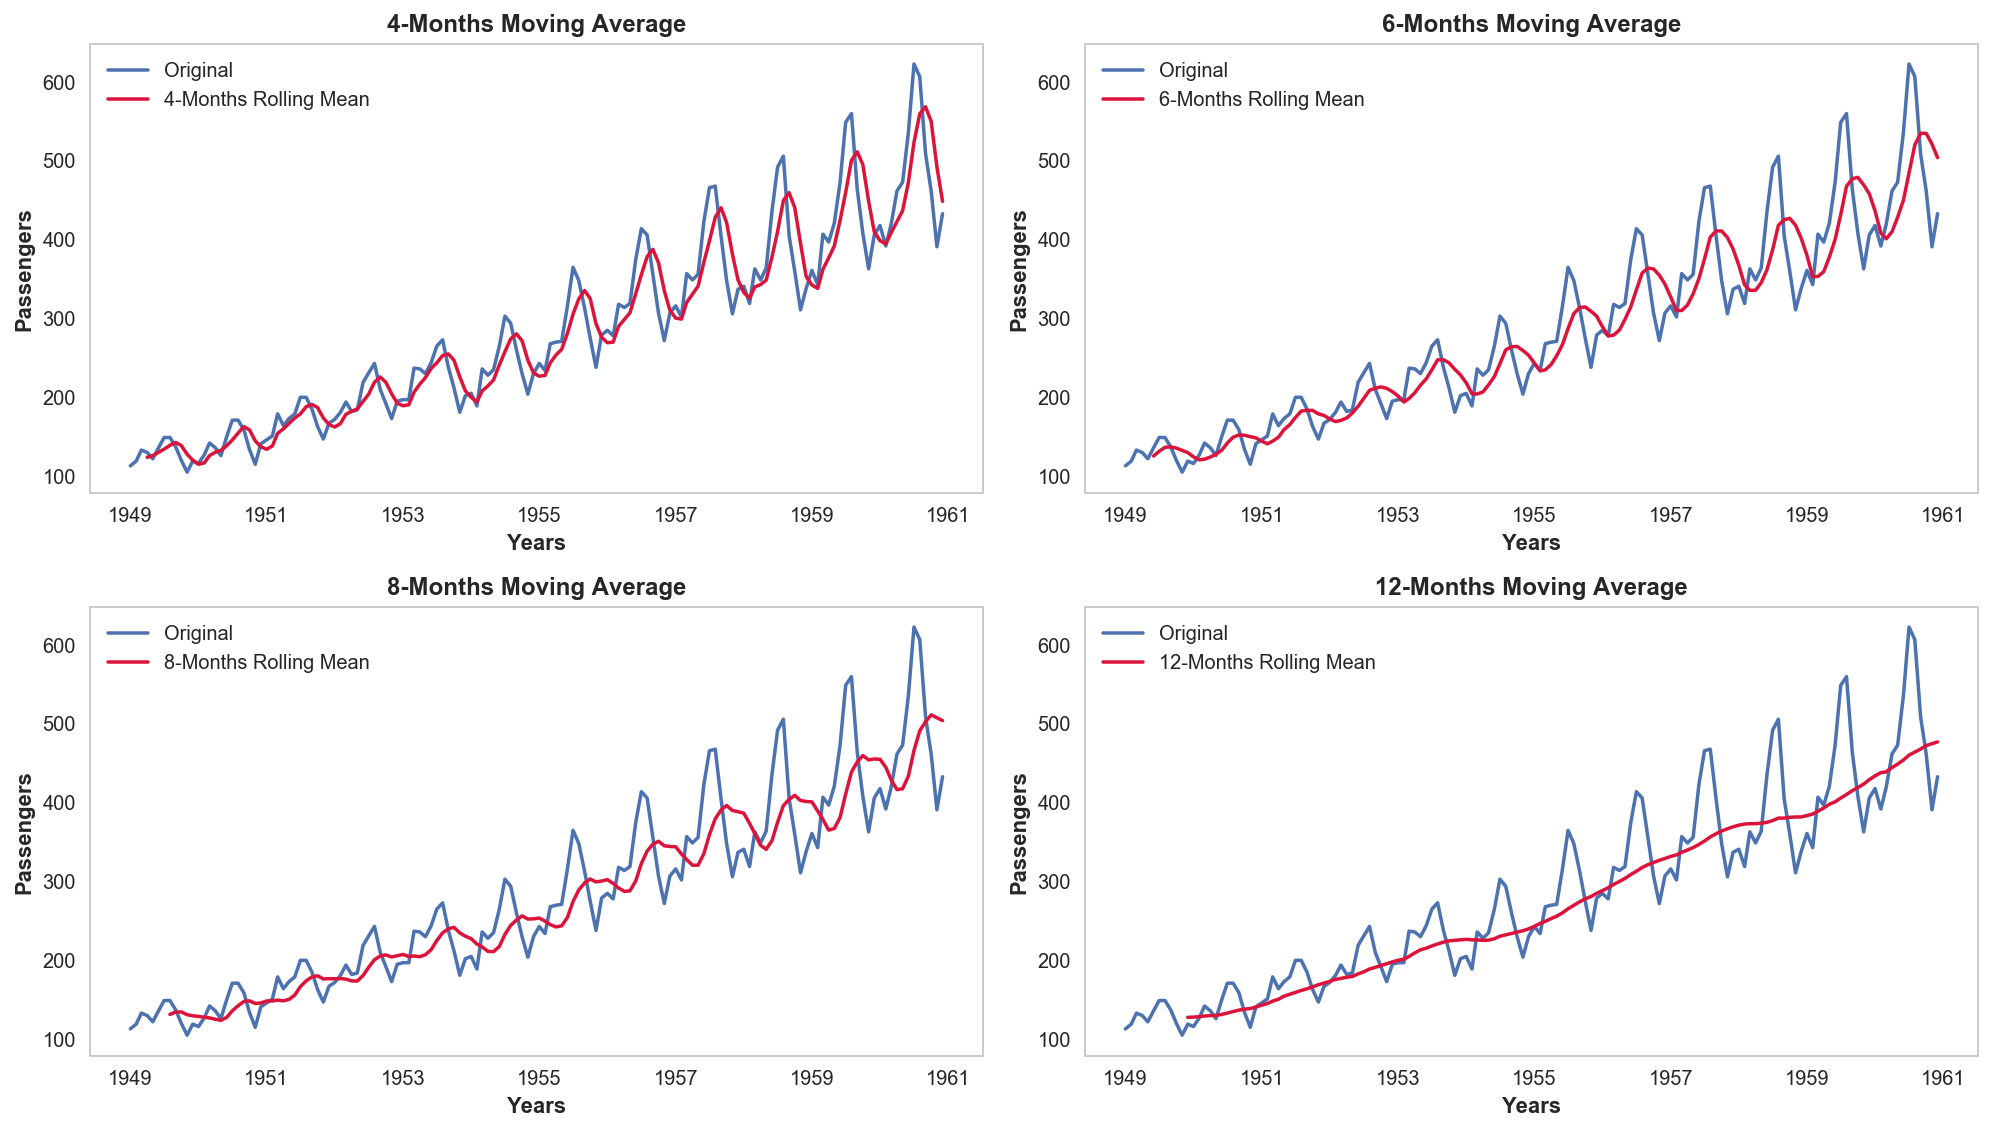

In [6]:
# define figure and axes
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False);
fig.set_figwidth(14);
fig.set_figheight(8);

# push data to each axe
#upper left
axes[0][0].plot(y.index, y, label='Original');
axes[0][0].plot(y.index, y.rolling(window=4).mean(), label='4-Months Rolling Mean', color='crimson');
axes[0][0].set_xlabel("Years");
axes[0][0].set_ylabel("Passengers");
axes[0][0].set_title("4-Months Moving Average");
axes[0][0].legend(loc='best');

# upper right
axes[0][1].plot(y.index, y, label='Original')
axes[0][1].plot(y.index, y.rolling(window=6).mean(), label='6-Months Rolling Mean', color='crimson');
axes[0][1].set_xlabel("Years");
axes[0][1].set_ylabel("Passengers");
axes[0][1].set_title("6-Months Moving Average");
axes[0][1].legend(loc='best');

# lower left
axes[1][0].plot(y.index, y, label='Original');
axes[1][0].plot(y.index, y.rolling(window=8).mean(), label='8-Months Rolling Mean', color='crimson');
axes[1][0].set_xlabel("Years");
axes[1][0].set_ylabel("Passengers");
axes[1][0].set_title("8-Months Moving Average");
axes[1][0].legend(loc='best');

# lower right
axes[1][1].plot(y.index, y, label='Original');
axes[1][1].plot(y.index, y.rolling(window=12).mean(), label='12-Months Rolling Mean', color='crimson');
axes[1][1].set_xlabel("Years");
axes[1][1].set_ylabel("Passengers");
axes[1][1].set_title("12-Months Moving Average");
axes[1][1].legend(loc='best');
plt.tight_layout();
plt.show()

As the rolling mean window is increased the curve becomes smoother

In [7]:
def plot_rolling_statistics(y, window=12):
    '''
    Plot rolling mean and rolling standard deviation for a given time series and window
    '''
    # calculate moving averages
    rolling_mean = pd.rolling_mean(y, window=window)
    rolling_std = pd.rolling_std(y, window=window)

    # plot statistics
    plt.plot(y, label='Original')
    plt.plot(rolling_mean, color='crimson', label='Moving average mean')
    plt.plot(rolling_std, color='darkslateblue', label='Moving average standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    return

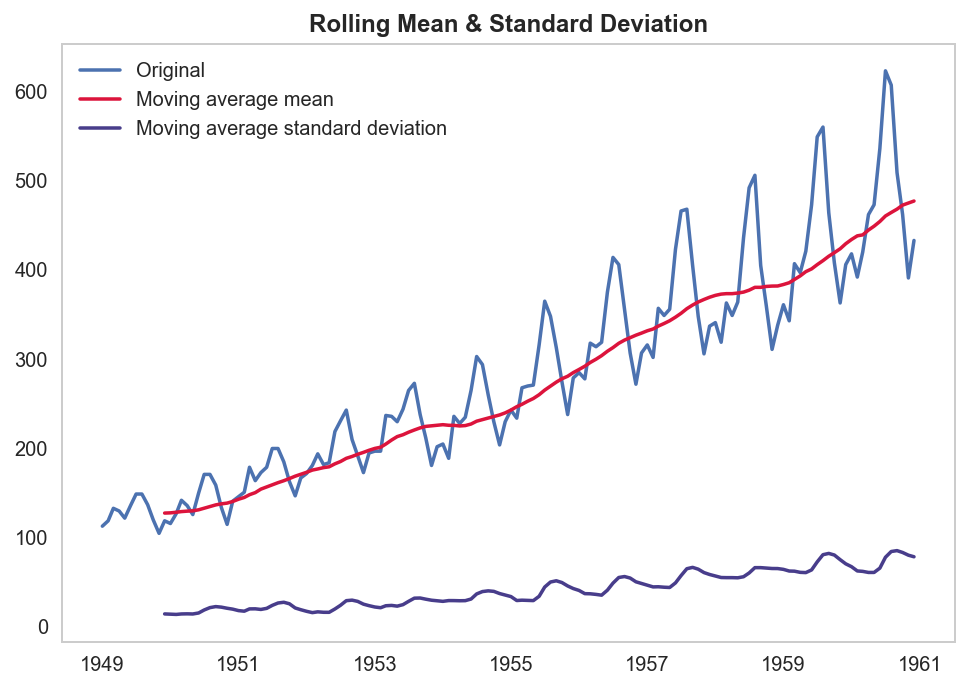

In [8]:
plot_rolling_statistics(y, window=12)

Again, judging from the rolling mean plot, it is evident that there is a trend in the data, i.e. the data is not trend stationary. However, it might not always be possible to rely on a visual analysis.

### Median Filtering

https://www.youtube.com/watch?v=likDxYXhNQY

In [17]:
from scipy import signal as sp_signal


def plot_median_filtered(y, window=12):
    '''
    Plot rolling mean and rolling standard deviation for a given time series and window
    '''
    # calculate moving averages
    median_filtered_mean = sp_signal.medfilt(y[0:142, window)

    # plot statistics
    plt.plot(y, label='Original')
    plt.plot(median_filtered_mean, color='crimson', label='Moving average mean')
    plt.legend(loc='best')
    plt.title('Median Filtered Series')
    plt.show(block=False)
    return

SyntaxError: invalid syntax (<ipython-input-17-d47db827c1b5>, line 9)

In [23]:
median_filtered_mean = sp_signal.medfilt(np.asarray(y[1:]), 12)

ValueError: Each element of kernel_size should be odd.

In [22]:
type(y[1:])

pandas.core.series.Series

In [10]:
plot_median_filtered(y)

ValueError: Each element of kernel_size should be odd.



## 3.3 Seasonality

People tend to go on vacation mainly during summer holidays. That is, at some time periods during the year people tend to use aircrafts more frequently. We could check this hypothesis of a seasonal effect by 

In [93]:
# create new columns to DataFrame by extracting a string representing 
# the time under the control of an explicit format string
# '%b' extracts the month in locale's abbreviated name from the index
pas = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
pas['Month'] = pas.index.strftime('%b')
pas['Year'] = pas.index.year

In [95]:
pas.tail()

,n_passengers,Month,Year
month,,,
1960-08-01,606,Aug,1960
1960-09-01,508,Sep,1960
1960-10-01,461,Oct,1960
1960-11-01,390,Nov,1960
1960-12-01,432,Dec,1960


In [36]:
# create new columns to DataFrame by extracting a string representing 
# the time under the control of an explicit format string
# '%b' extracts the month in locale's abbreviated name from the index
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
df['Month'] = df.index.strftime('%b')
df['Year'] = df.index.year

# create nice axes names
month_names = pd.date_range(start='1949-01-01', periods=12, freq='MS').strftime('%b')

# reshape data using 'Year' as index and 'Month' as column
df_piv_line = df.pivot(index='Month', columns='Year', values='n_passengers')
df_piv_line = df_piv_line.reindex(index=month_names)

In [37]:
df_piv_line

Year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
Month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


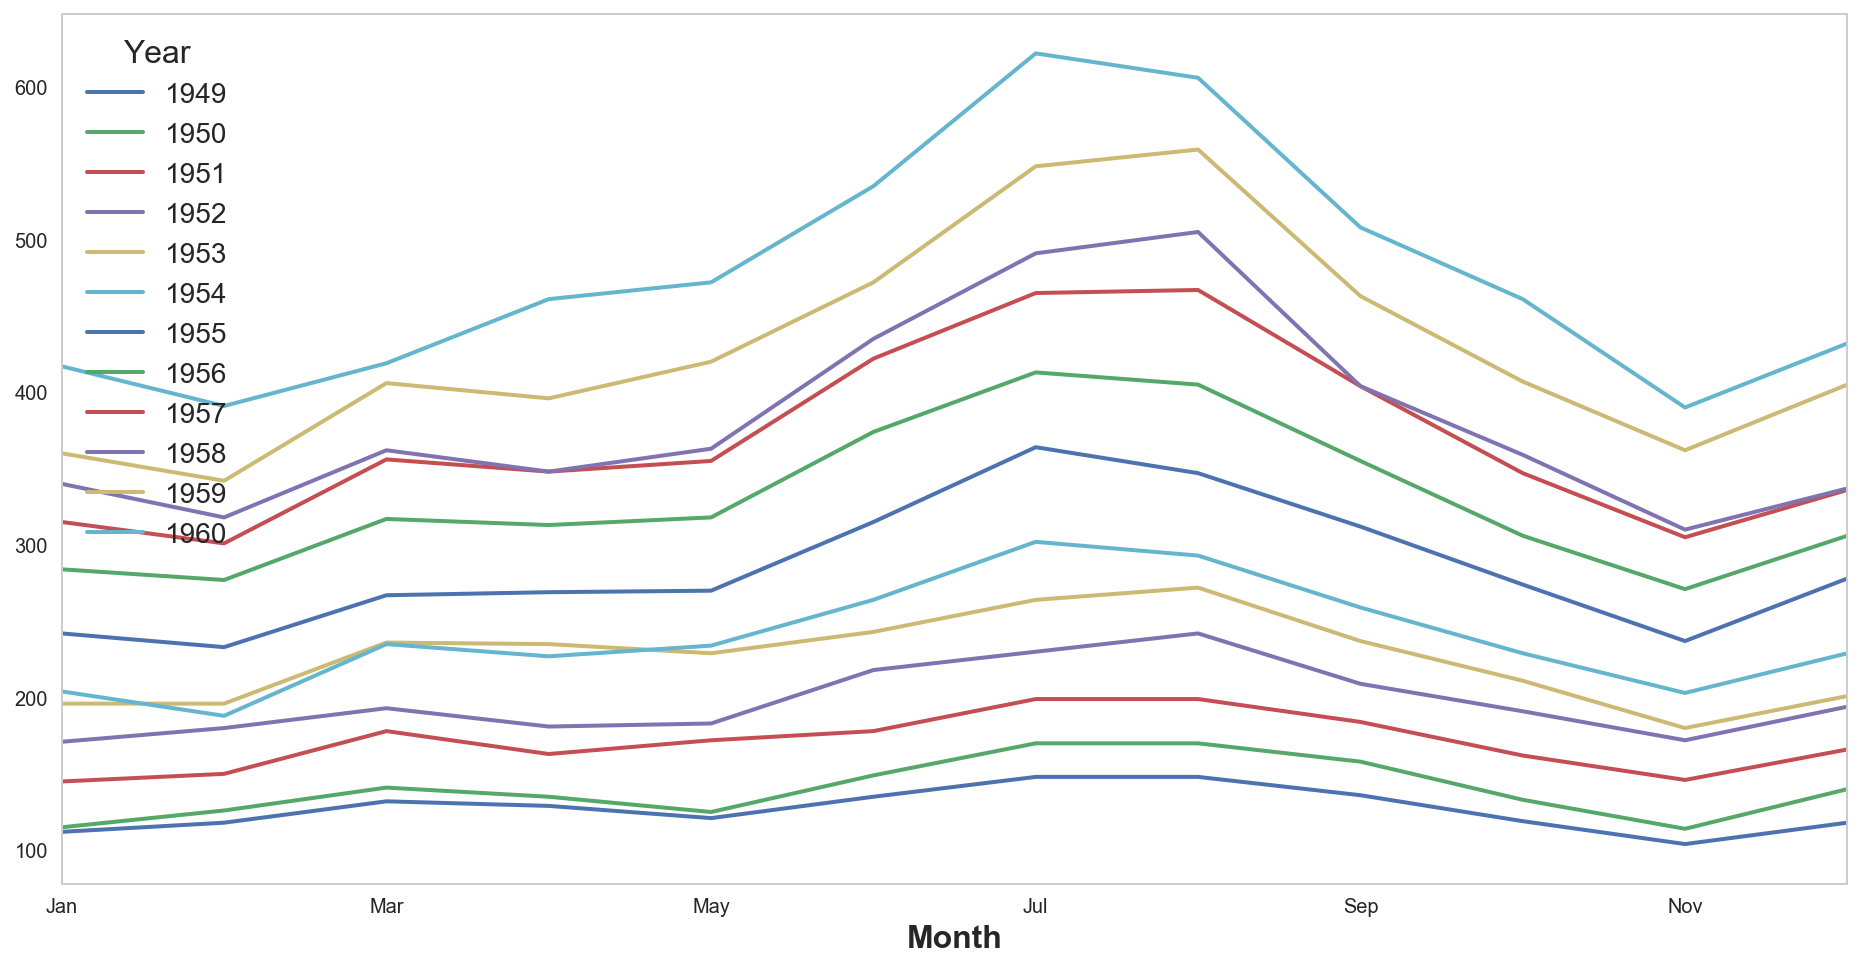

In [38]:
df_piv_line.plot();
plt.show()

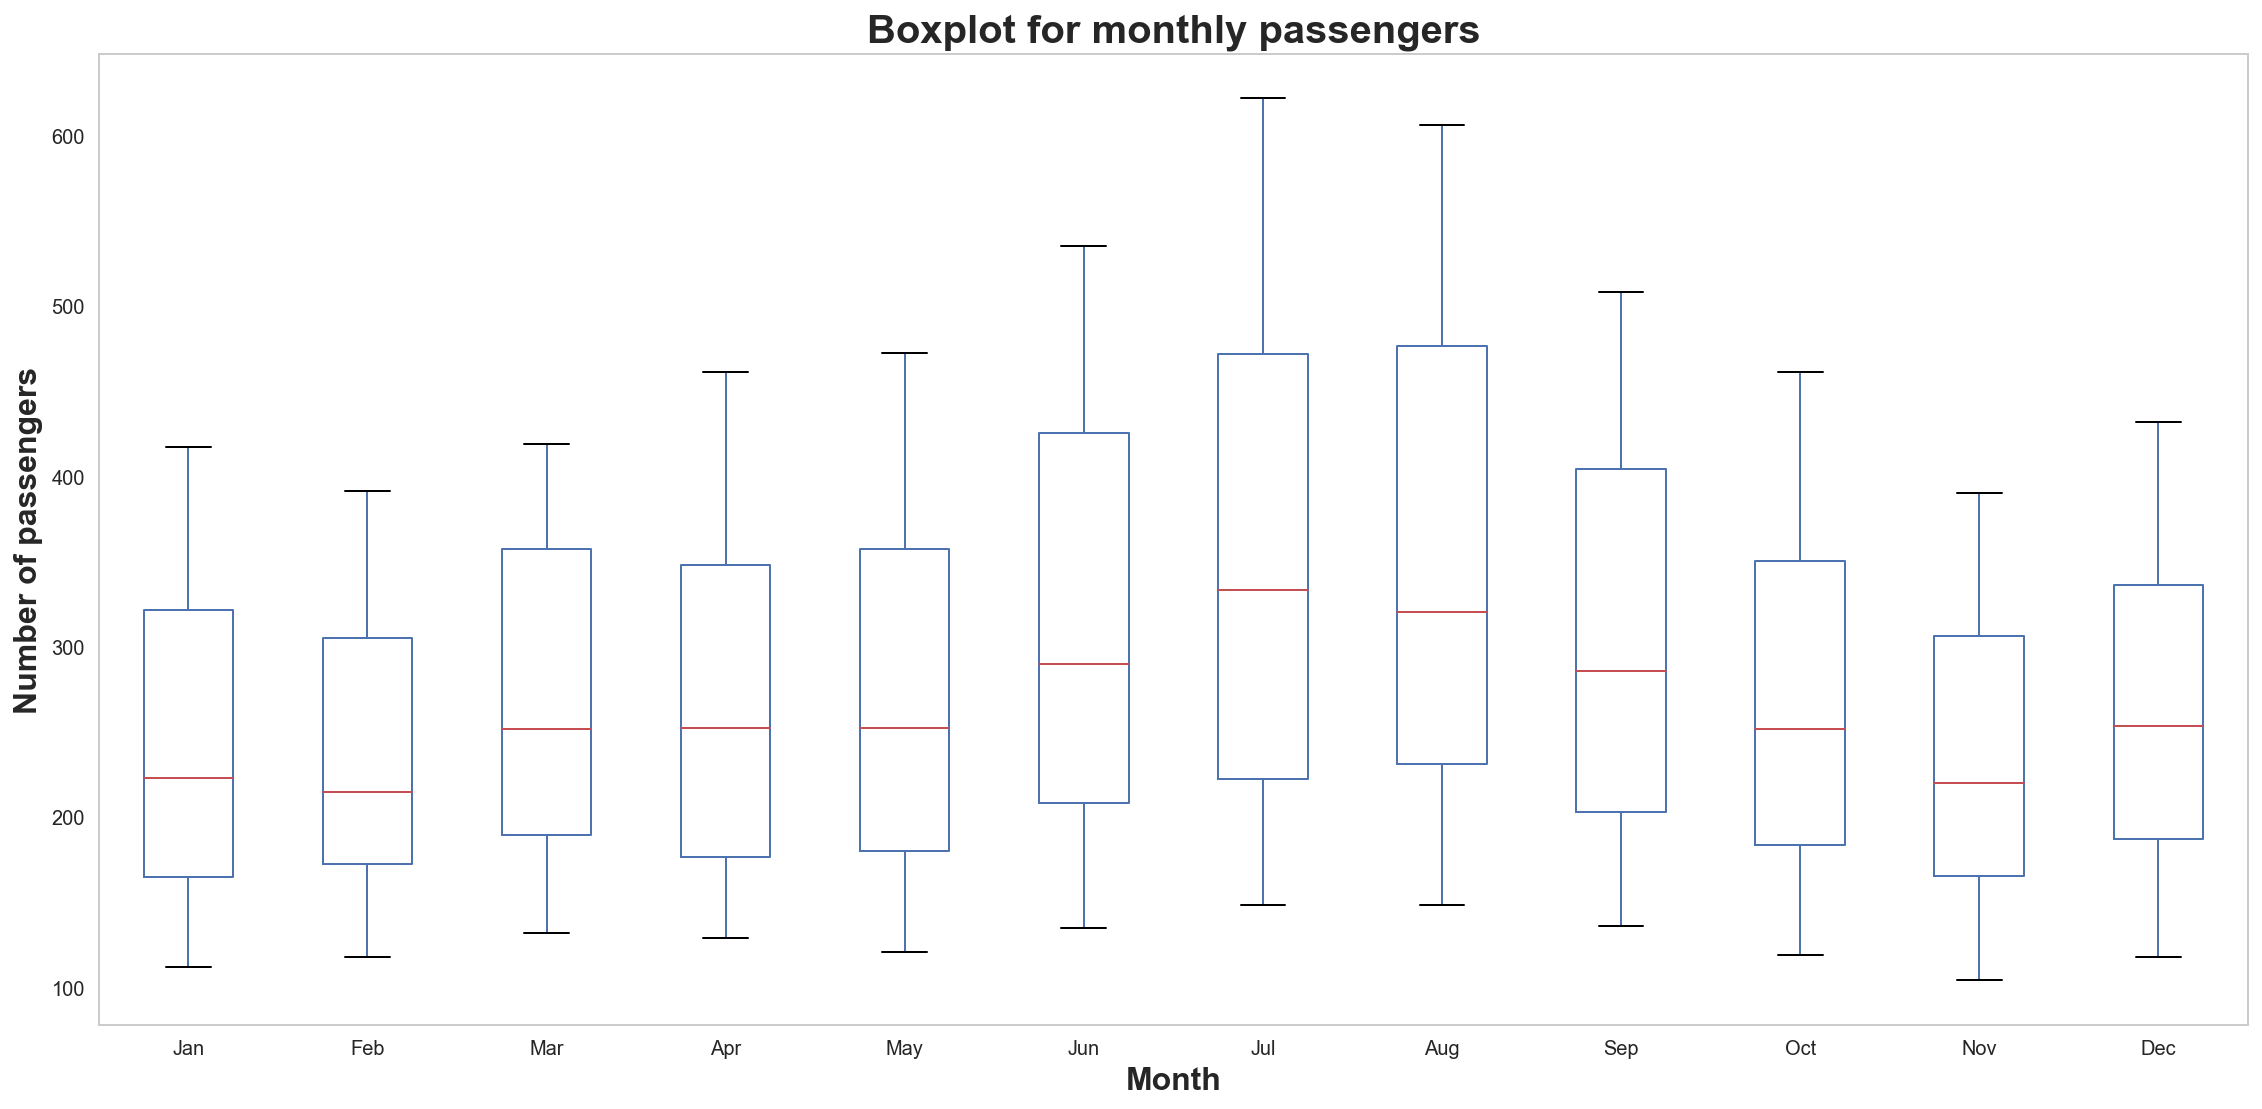

In [39]:
# create new columns to DataFrame by extracting a string representing 
# the time under the control of an explicit format string
# '%b' extracts the month in locale's abbreviated name from the index
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
df['Month'] = df.index.strftime('%b')
df['Year'] = df.index.year

# create nice axes names
month_names = pd.date_range(start='1949-01-01', periods=12, freq='MS').strftime('%b')

# reshape date
df_piv_box = df.pivot(index='Year', columns='Month', values='n_passengers')

# reindex pivot table with 'month_names'
df_piv_box = df_piv_box.reindex(columns=month_names)

# create a box plot
fig, ax = plt.subplots();
df_piv_box.plot(ax=ax, kind='box');
ax.set_title('Boxplot for monthly passengers');
ax.set_xlabel('Month');
ax.set_ylabel('Number of passengers');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();

plt.show()

<strong>Inference</strong>
<ul>
<li>The number of airline passengers have been increasing without fail every year</li>
<li>July and August are the peak months for airline passengers and the variance and the mean for these months are also much higher than any of the other months</li>
<li>There is a seasonal cycle of 12 months where the mean value of each month starts with an increasing trend in the beginneing of the year and drops down toward the end of the year</li>
</ul>

As we have expected there is a prevelant tendency of using more aircrafts during the summer months. 

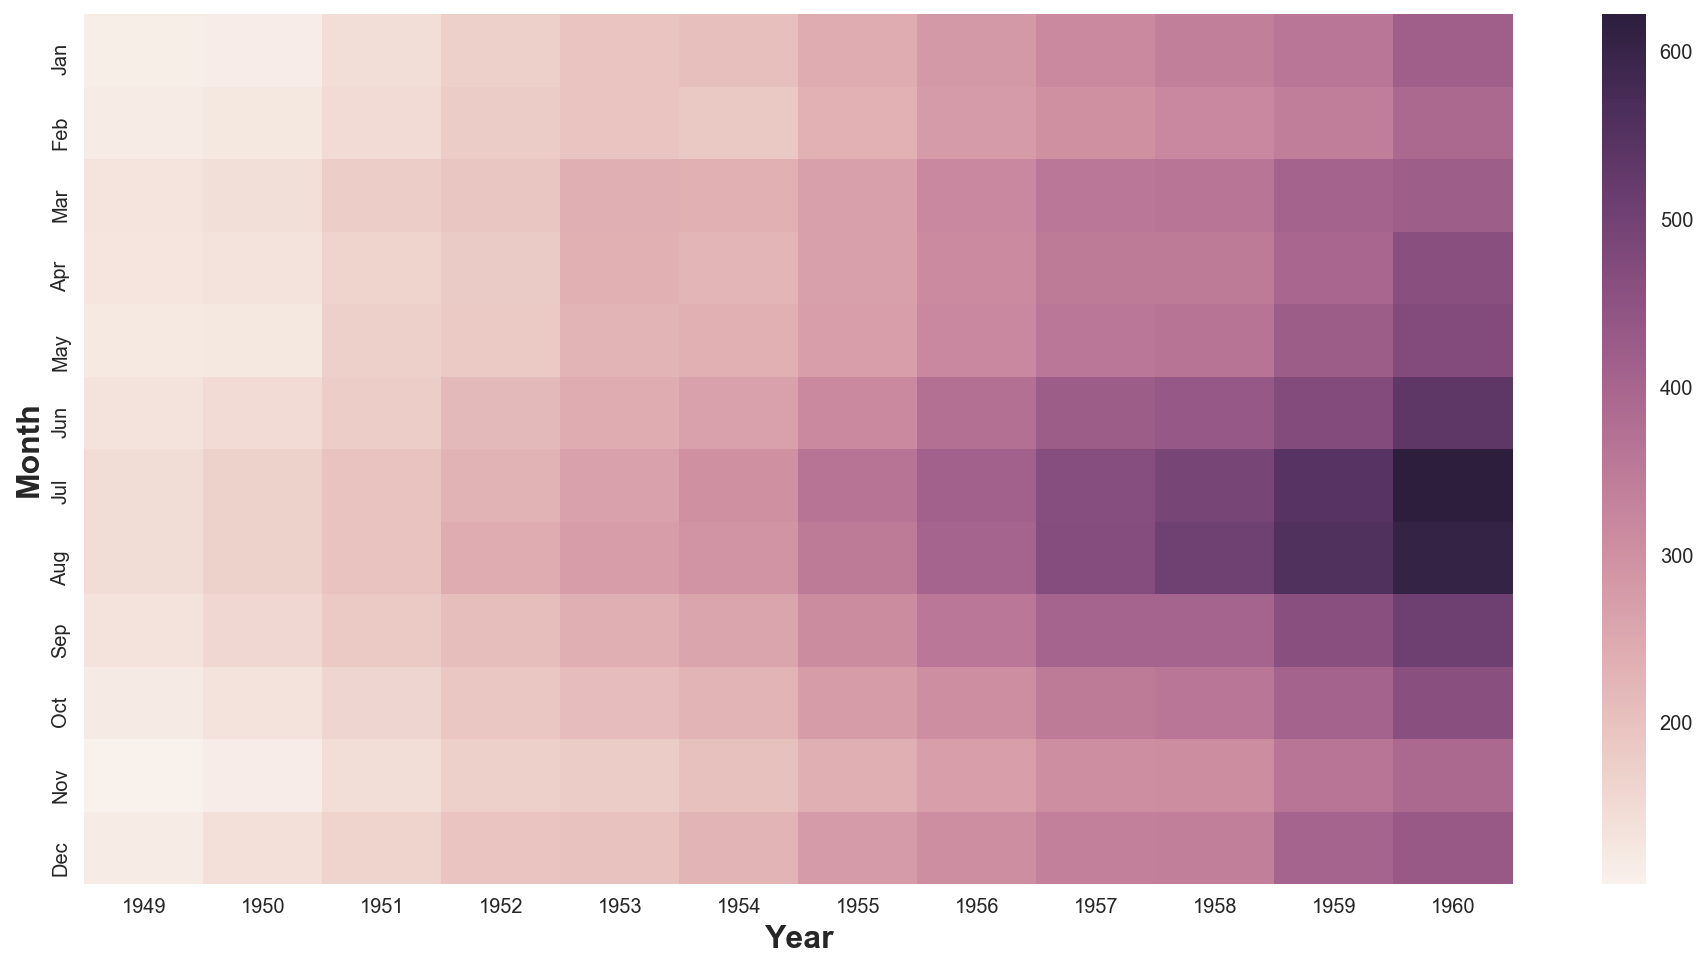

In [42]:
# plot heatmap
sns.heatmap(df_piv_line, annot=False)

In [43]:
# drop the new columns from original data frame
#pas = pas.drop(['Month', 'Year'], axis=1)

## 3.4 Noise

To understand the underlying pattern in the number of itnernational airline passengers, we assume a <strong>multiplicative</strong> time series decomposition model with the following equation

$$
y_t = d_t \cdot s_t \cdot \varepsilon_t
$$

The <code>statsmodels</code> library grants access to predefined methods for decomposing time series automatically. Using the code below calls the <code>seasonal_decomposition</code> method which will return the original time series, the trend component, seasonality component. A specification of wether to apply an additive or multiplicative model is required.

<strong>However</strong>, be aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

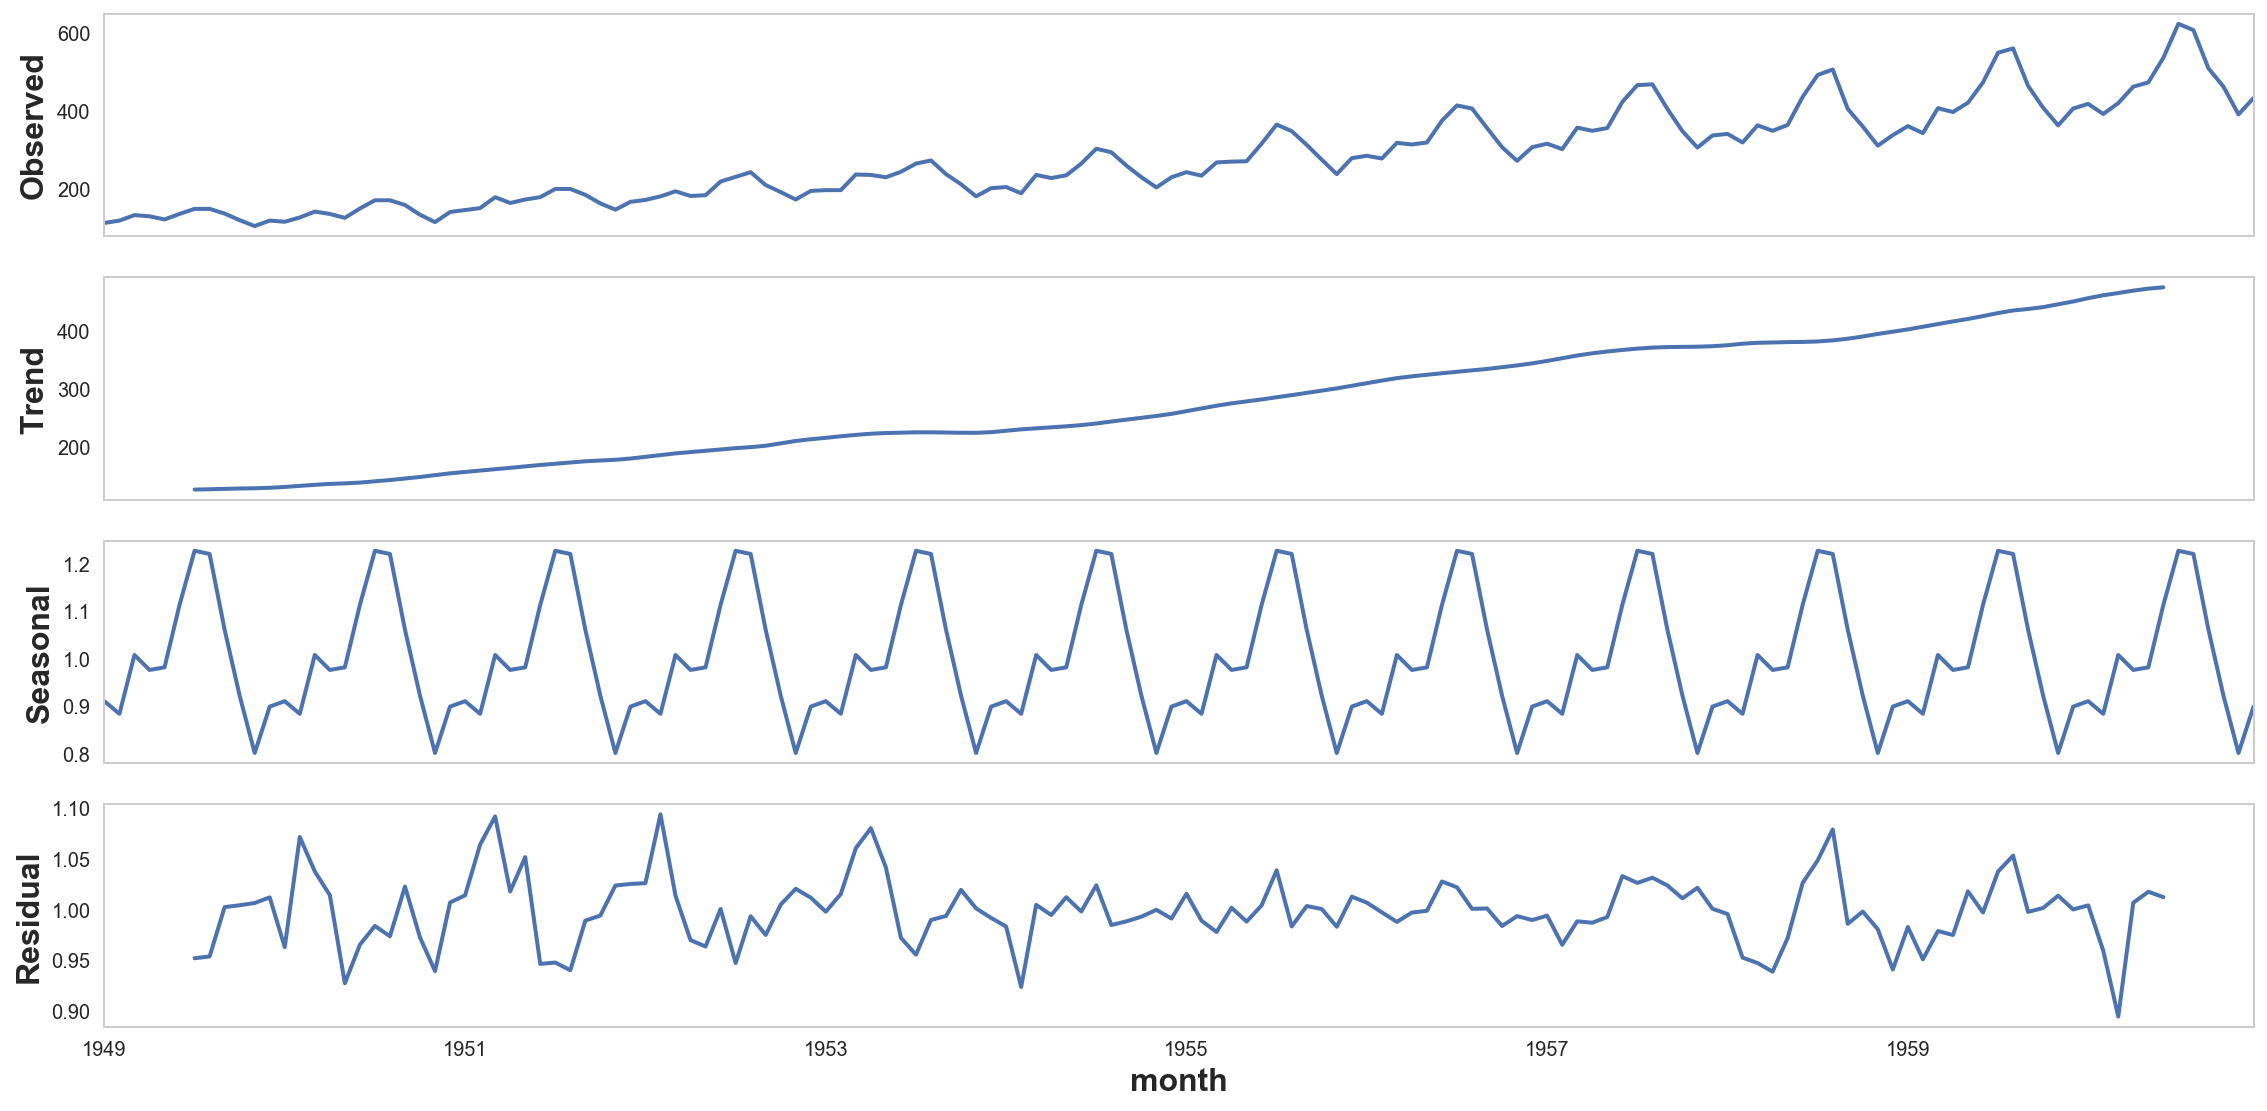

In [45]:
# multiplicative seasonal decomposition
decomp = seasonal_decompose(y, model='multiplicative')
decomp.plot();
plt.show()

<strong>Inference</strong>
<ul>
<li><strong>Trend</strong> - The 12 month moving average calculated earlier looks quite alike. Hence, we could have used linear regression to estimate the trend in this data.</li>
<li><strong>Seasonality</strong> - The seasonal plot displays a consistent month-to-month pattern. The monthly seasonal components are average values for a month after trend removal</li>
<li><strong>Noise</strong> - is the residual series left after removing the trend and seasonality components</li>
</ul>

Alternatively and for comparison, an <strong>additive</strong> model would be

$$
y_t = d_t + s_t + \varepsilon_t
$$

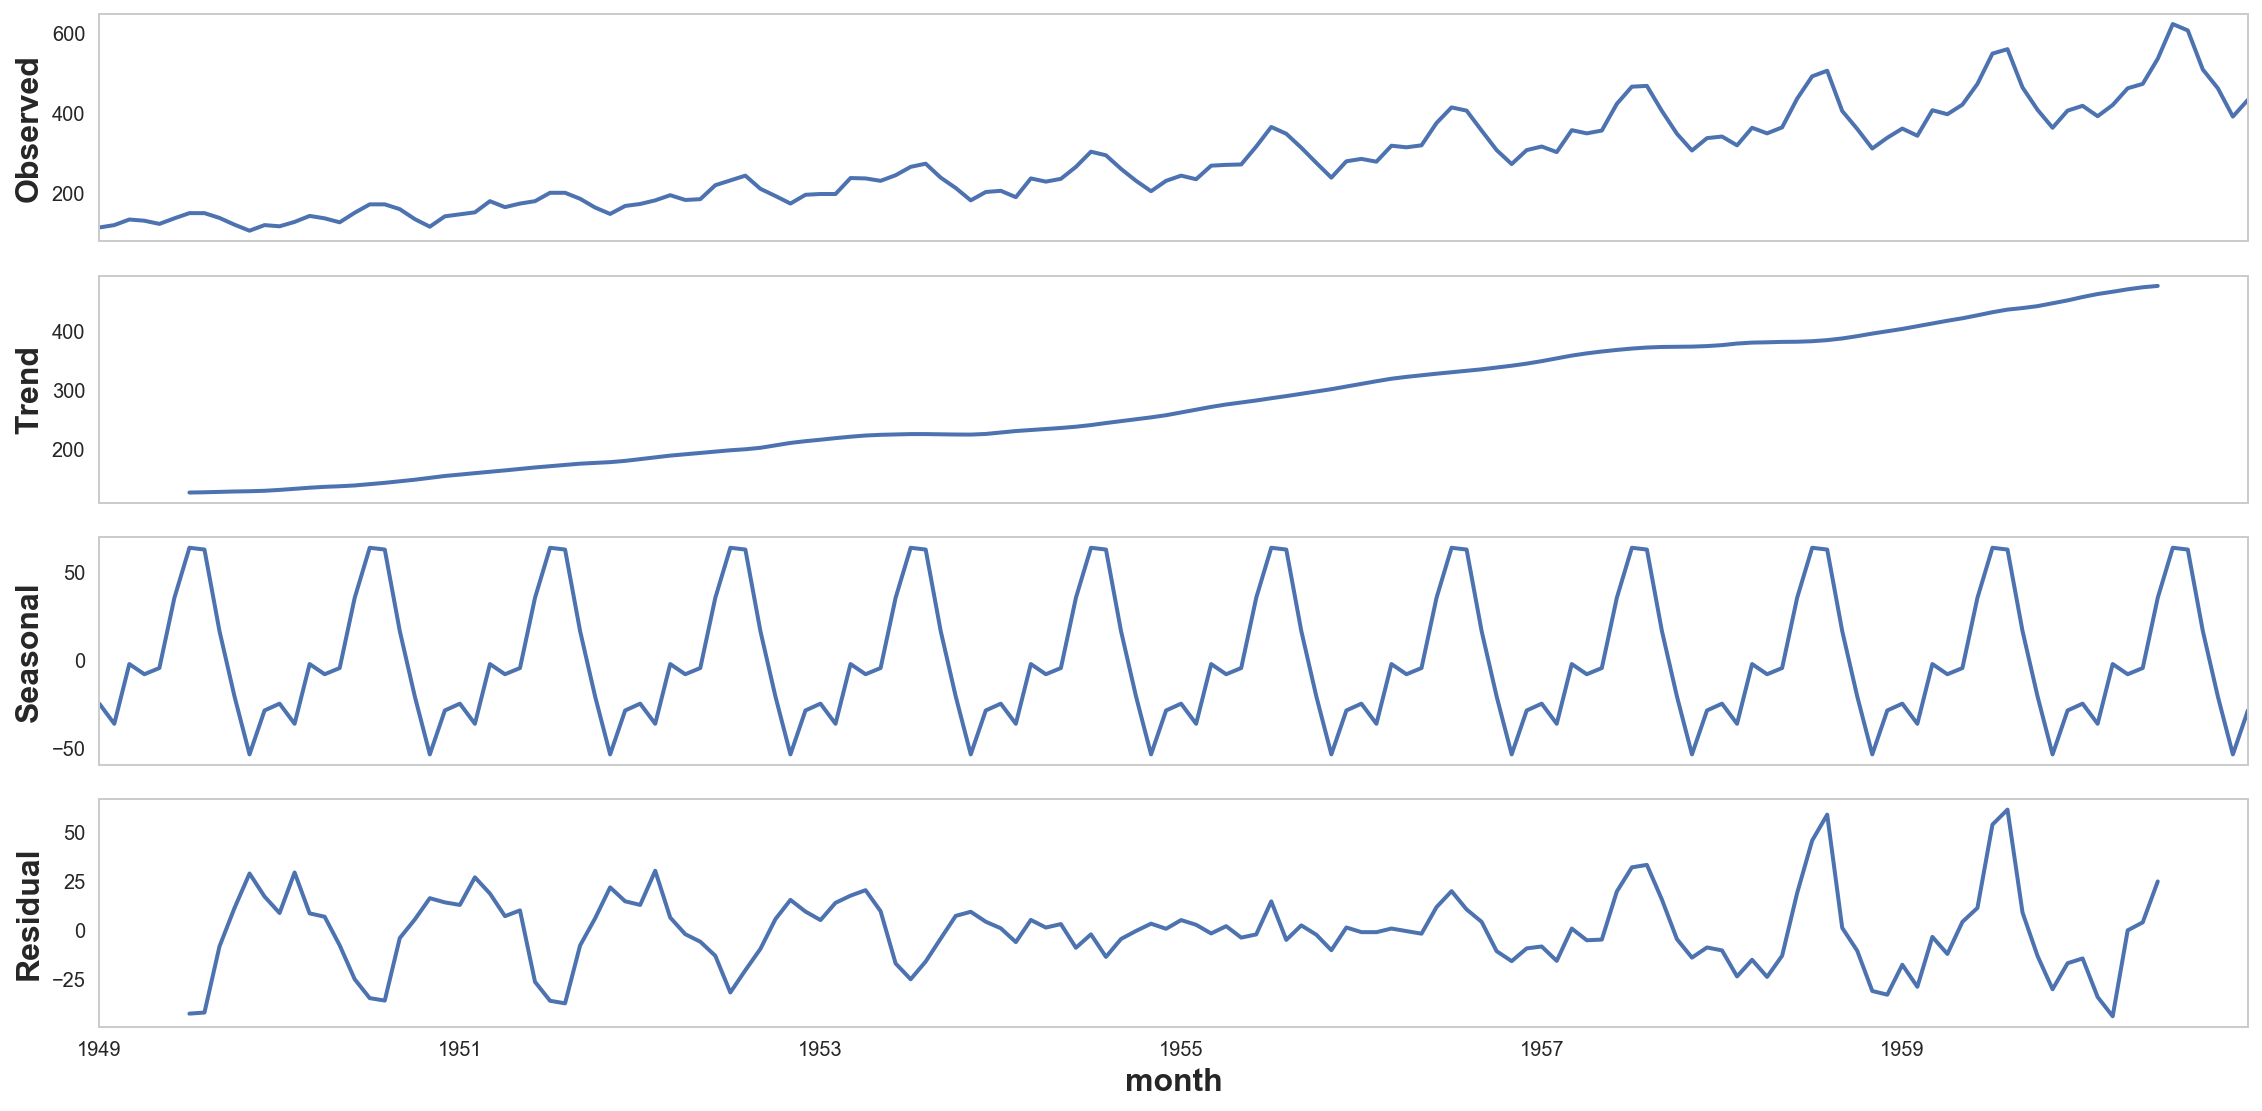

In [46]:
# additive seasonal decomposition
decomp = seasonal_decompose(y, model='additive')
decomp.plot();
plt.show()

<strong>Inference</strong>
<ul>
<li>Difference in the scale of the decomposed time series when compared to the multiplicative model</li>
<li>There is still a pattern left in the residual series</li>
<li>The high residual values indicate that the application of a multiplicative model is preferable</li>
</ul>

<strong>Best Practice</strong>
<ul>
<li>When the data contains negative values, e.g. a data series on average temperatures, an additive model should be used</li>
</ul>